In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from strategy_v2.Strategy import *
from strategy_v2.Strategy.MVO import *
from strategy_v2.Strategy.MVO.AlphaModel import *
from strategy_v2.Strategy.MVO.RiskModel import *
from strategy_v2.TradingSubSystem import *
from strategy_v2.Portfolio import *
from strategy_v2.TransactionCost import *
from strategy_v2.Executor import *
from utils.data_helper import *
from utils.data import *
from utils.performance import *

In [3]:
instruments = [
    'META',
    'TSLA',
    'NVDA',
    'AAPL',
    'EWY',
    'DXJ',
    'BRK-B',
    'SPY',
    'QQQ',
    'NANC',
    'BTC',
    #'DJT',
]

end_date = get_today()
start_date = pd.to_datetime(datetime(2024, 1, 3))
start_date = pd.to_datetime(datetime(2023, 2, 7))
max_leverage = 1
#vol_target = 0.25
vol_target = None

# Notes

- 2024-08-28: Tested expected return prediction with RandomForest, XGB, LGBM. None of them outperforms the SMA Model. LGBM is able to achieve a similar performance as SMA model and generally train faster.</br>

    | Measure                | ^SPX      | MVO - SMA1 | MVO - RandomForest1 | MVO - XGB1 | MVO - LGBM1 |
    |------------------------|-----------|------------|---------------------|------------|-------------|
    | Cumulative Return      | 1.173503  | 2.072994   | 1.662573            | 1.471717   | 2.023378    |
    | Annualized Return      | 0.076775  | 0.301537   | 0.221185            | 0.176047   | 0.296252    |
    | Annualized Volatility  | 0.180081  | 0.226417   | 0.240133            | 0.243953   | 0.243120    |
    | Annualized Sharpe Ratio| 0.240438  | 1.183923   | 0.781685            | 0.584416   | 1.080844    |
    | Maximum Drawdown       | -0.254251 | -0.271732  | -0.323658           | -0.380737  | -0.296535   |

    Models are shared the same hyperparameters: lookback (train days) = 10 days and gamma=10, hhi=0.2


## Leverage 
##### 1. capital (Stock MV / last leverage), 2. new leverage
2024-09-06: $169,336, 96.69%

2024-09-20: $172,168, 93.52%

2024-10-04: $176,235, 100%

2024-10-18: $177,831, 100%

2024-11-01: $175,558, 100%

2024-11-09: $181,511

<Axes: >

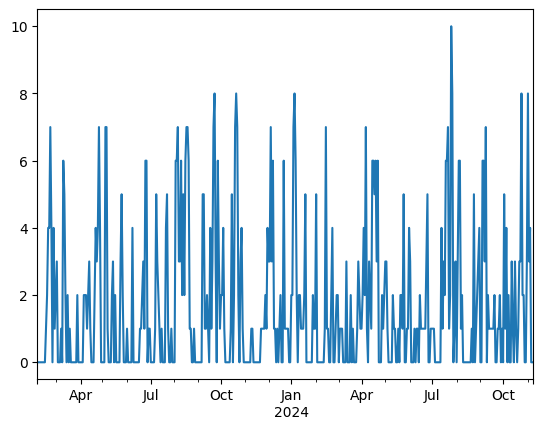

In [10]:
portfolio.systems[3].strategy[0].alphas.sum(axis=1).plot()

In [14]:
portfolio = PortfolioStandard(
    capital=181511,
    name='MVOPortfolio',        
    rebalance_iter=RebalancerIter('0 0 * * Fri', 1),        
    tc_model=TransactionCostFutu(), 
    systems_style=SystemStyle.VERTICAL,
    systems=[        
        # Mid terms signals => 30days return / diversified        
        TradingSubSystemSingle(vol_target=vol_target, instruments=instruments, strategy=[MeanVarianceOpt(alpha_model=RollingMean(30), risk_model=RollingMeanCov(30), gamma=10, hhi=0.01, confidence=2)], max_leverage=max_leverage, offset=60),

        # Short terms signals => 10days returns / less diversified
        TradingSubSystemSingle(vol_target=vol_target, instruments=instruments, strategy=[MeanVarianceOpt(alpha_model=RollingMean(10), risk_model=RollingMeanCov(10), gamma=10, hhi=0.1, confidence=1)], max_leverage=max_leverage, offset=60),         

        # Mean Revert signals => 2days RSI / concentrated
        TradingSubSystemSingle(vol_target=vol_target, instruments=instruments, strategy=[MeanVarianceOpt(alpha_model=RSI(2,10), risk_model=ZeroCov(), gamma=0, hhi=0, confidence=0.5)], max_leverage=max_leverage, offset=200),                        

        # Mean Revert signals => Double7 / concentrated
        TradingSubSystemSingle(vol_target=vol_target, instruments=instruments, strategy=[MeanVarianceOpt(alpha_model=Double7(5), risk_model=ZeroCov(), gamma=0, hhi=0, confidence=0.5)], max_leverage=max_leverage, offset=200),                        
    ]
)

portfolio.set_start_date(start_date)
portfolio.set_end_date(end_date)
portfolio.backtest_subsystems()
portfolio.optimize()
portfolio.backtest()
portfolio.rebalance()
portfolio.performance(show_all_rets=True)

2024-11-10 02:17:51,542 - TradingSubSystemSingle [MVO - RollingMean2] - INFO - Generating position for strategy MVO - RollingMean2 between 2023-02-06 and 2024-11-09......
100%|██████████| 460/460 [00:05<00:00, 81.88it/s] 
2024-11-10 02:17:57,267 - TradingSubSystemSingle [MVO - RollingMean2] - INFO - Volatility Target = nan% | Price Volatility = 11.4% | Last Scale Factor = 1.00
2024-11-10 02:17:57,277 - TradingSubSystemSingle [MVO - RollingMean1] - INFO - Generating position for strategy MVO - RollingMean1 between 2023-02-06 and 2024-11-09......
100%|██████████| 460/460 [00:07<00:00, 61.90it/s] 
2024-11-10 02:18:04,790 - TradingSubSystemSingle [MVO - RollingMean1] - INFO - Volatility Target = nan% | Price Volatility = 16.6% | Last Scale Factor = 1.00
2024-11-10 02:18:04,804 - TradingSubSystemSingle [MVO - RSI20.5] - INFO - Generating position for strategy MVO - RSI20.5 between 2023-02-06 and 2024-11-09......
100%|██████████| 460/460 [00:45<00:00, 10.12it/s]
2024-11-10 02:18:50,276 - Tra

,Rebalanced Portfolio,Optimized Portfolio,^SPX,MVO - RollingMean2,MVO - RollingMean1,MVO - RSI20.5,MVO - Double50.5
Measure,,,,,,,
Cumulative Return,1.824653,1.947021,1.439851,1.387597,1.600265,1.132324,1.201468
Annualized Return,0.369046,0.404569,0.215420,0.191834,0.276732,0.075781,0.109684
Annualized Volatility,0.231380,0.225209,0.126202,0.104274,0.135347,0.101352,0.102613
Annualized Sharpe Ratio,1.465828,1.663728,1.470163,1.553130,1.823821,0.452860,0.777691
Maximum Drawdown,-0.196873,-0.147492,-0.102766,-0.081834,-0.085735,-0.072018,-0.089333


In [70]:
portfolio.get_position_for_trade().tail(20)

2024-11-10 01:46:15,433 - Standard Portfolio ({self.name}) - CRITICAL - Portfolio target capital is not specified, use initial backtest capital of $181,511
2024-11-10 01:46:15,435 - Standard Portfolio ({self.name}) - INFO - Generate trade position based on target capital of $181,511


,AAPL,BRK-B,BTC,DXJ,EWY,META,NANC,NVDA,QQQ,SPY,TSLA
Date,,,,,,,,,,,
2024-10-14,0.0,6.0,0.0,47.0,0.0,92.0,156.0,536.0,14.0,13.0,116.0
2024-10-15,0.0,6.0,0.0,47.0,0.0,92.0,156.0,536.0,14.0,13.0,116.0
2024-10-16,0.0,6.0,0.0,47.0,0.0,92.0,156.0,536.0,14.0,13.0,116.0
2024-10-17,0.0,6.0,0.0,47.0,0.0,92.0,156.0,536.0,14.0,13.0,116.0
2024-10-18,67.0,22.0,7432.0,32.0,0.0,18.0,445.0,423.0,20.0,22.0,0.0
2024-10-21,67.0,22.0,7432.0,32.0,0.0,18.0,445.0,423.0,20.0,22.0,0.0
2024-10-22,67.0,22.0,7432.0,32.0,0.0,18.0,445.0,423.0,20.0,22.0,0.0
2024-10-23,67.0,22.0,7432.0,32.0,0.0,18.0,445.0,423.0,20.0,22.0,0.0
2024-10-24,67.0,22.0,7432.0,32.0,0.0,18.0,445.0,423.0,20.0,22.0,0.0


# Execute the Portfolio

In [63]:
executor = ExecutorFutu(is_test=False)
executor.set_portfolio(portfolio)
orders = executor.execute(px_interval='5m')
orders

2024-11-09 02:14:01,256 - ExecutorFutu - INFO - market: US
2024-11-09 02:14:01,260 - ExecutorFutu - INFO - Cancel all orders first before executing.....


2024-11-09 02:14:01,272 | 82589 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=19, host=127.0.0.1, port=11111, user_id=18214795
2024-11-09 02:14:01,789 | 82589 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=19


2024-11-09 02:14:04,794 - Standard Portfolio ({self.name}) - CRITICAL - Portfolio target capital is not specified, use initial backtest capital of $181,511
2024-11-09 02:14:04,799 - Standard Portfolio ({self.name}) - INFO - Generate trade position based on target capital of $181,511
2024-11-09 02:14:04,825 - ExecutorFutu - INFO - Execute Standard Portfolio ({self.name}) position based on 2024-11-08


2024-11-09 02:14:04,830 | 82589 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=20, host=127.0.0.1, port=11111, user_id=18214795


2024-11-09 02:14:04,858 - Futu - INFO - 10 Positions: US.TSLA, US.SPY, US.QQQ, US.NVDA, US.NANC, US.META, US.EWY, US.DXJ, US.BRK.B, US.AAPL


2024-11-09 02:14:04,861 | 82589 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=20


,instrument,target,current,turnover
0,AAPL,0.0,113.0,-113.0
1,BRK-B,1.0,1.0,0.0
2,DXJ,386.0,386.0,0.0
3,EWY,33.0,33.0,0.0
4,META,40.0,40.0,0.0
5,NANC,380.0,380.0,0.0
6,NVDA,230.0,339.0,-109.0
7,QQQ,33.0,33.0,0.0
8,SPY,9.0,9.0,0.0
9,TSLA,137.0,137.0,0.0


[*********************100%***********************]  10 of 10 completed


2024-11-09 02:14:05,358 - ExecutorFutu - INFO - getting last 5m prices since 2024-11-08 13:10:00 for order limit price


2024-11-09 02:14:05,362 | 82589 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=21, host=127.0.0.1, port=11111, user_id=18214795


2024-11-09 02:14:05,812 - Futu - INFO - Placed Order: {'code': 'US.AAPL', 'price': 227.05, 'qty': 113.0, 'trd_side': 'SELL', 'order_type': 'NORMAL', 'market': 'US', 'trd_env': 'REAL'}


2024-11-09 02:14:05,814 | 82589 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=21
2024-11-09 02:14:08,846 | 82589 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=22, host=127.0.0.1, port=11111, user_id=18214795


2024-11-09 02:14:09,117 - Futu - INFO - Placed Order: {'code': 'US.NVDA', 'price': 147.56, 'qty': 109.0, 'trd_side': 'SELL', 'order_type': 'NORMAL', 'market': 'US', 'trd_env': 'REAL'}


2024-11-09 02:14:09,119 | 82589 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=22


,code,stock_name,trd_side,order_type,order_status,order_id,qty,price,create_time,updated_time,...,remark,time_in_force,fill_outside_rth,aux_price,trail_type,trail_value,trail_spread,currency,portfolio,date
0,US.AAPL,苹果,SELL,NORMAL,SUBMITTING,5440645071979491144,113.0,227.05,2024-11-08 13:14:05,2024-11-08 13:14:05,...,Standard Portfolio ({self.name}),DAY,False,N/A,N/A,N/A,N/A,USD,Standard Portfolio ({self.name}),2024-11-08
0,US.NVDA,英伟达,SELL,NORMAL,SUBMITTING,9106552484285761811,109.0,147.56,2024-11-08 13:14:09,2024-11-08 13:14:09,...,Standard Portfolio ({self.name}),DAY,False,N/A,N/A,N/A,N/A,USD,Standard Portfolio ({self.name}),2024-11-08


# Calibration Portfolios

In [ ]:
import itertools

def calbiration(start_date, end_date, params):
    sumamry = []

    for p in params:
        portfolio = PortfolioStandard(
            capital=169336.48958837058,
            name='MVOPortfolio',        
            rebalance_iter=RebalancerIter('0 0 * * Fri', 2),        
            tc_model=TransactionCostFutu(), 
            systems=[                                        
                TradingSubSystemSingle(vol_target=vol_target, instruments=instruments,  strategy=[MeanVarianceOptLGBM(gamma=10, hhi=0.2, lookback=10, confidence=1, train_days=p[0], forecast=p[1])], max_leverage=max_leverage, offset=60),                
            ]
        )
        portfolio.set_start_date(start_date)
        portfolio.set_end_date(end_date)
        portfolio.backtest_subsystems()

        ret = (portfolio.ret).mean(axis=1)
        res = performance_summary(ret)
        del res['strategy']
        res['train_days'] = p[0]
        res['forecast'] = p[1]
        sumamry.append(res)

    summary = pd.DataFrame(sumamry)
    summary = summary.set_index(['train_days', 'forecast'])    
    return summary

start_date = pd.to_datetime(datetime(2023,1,1))
end_date = get_today()

forcasts = np.arange(1,20,2)
train_days = forcasts * 3
params = list(itertools.product(train_days, forcasts))
params = [[p[0], p[1]] for p in params if p[0] > p[1]]

summary = calbiration(start_date, end_date, params)

2024-08-28 02:41:01,504 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Generating position for strategy MVO - LGBM1 between 2022-12-30 and 2024-08-27......
100%|██████████| 433/433 [00:41<00:00, 10.49it/s]
2024-08-28 02:41:42,847 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Volatility Target = 25.0% | Price Volatility = 34.7% | Last Scale Factor = 0.71
2024-08-28 02:41:42,852 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Generating position for strategy MVO - LGBM1 between 2022-12-30 and 2024-08-27......
100%|██████████| 433/433 [00:44<00:00,  9.78it/s]
2024-08-28 02:42:27,176 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Volatility Target = 25.0% | Price Volatility = 30.1% | Last Scale Factor = 0.83
2024-08-28 02:42:27,183 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Generating position for strategy MVO - LGBM1 between 2022-12-30 and 2024-08-27......
100%|██████████| 433/433 [00:42<00:00, 10.30it/s]
2024-08-28 02:43:09,268 - TradingSubSystemSingle [MVO - LGBM1] - INFO - Vol